In [1]:
import magma as m
m.set_mantle_target("coreir")
import mantle

def DefineShiftRegister(n, init=0, has_ce=False, has_reset=False):
    class _ShiftRegister(m.Circuit):
        name = 'ShiftRegister_{}_{}_{}_{}'.format(n, init, has_ce, has_reset)
        IO = ['I', m.In(m.Bit), 'O', m.Out(m.Bit)] + \
               m.ClockInterface(has_ce, has_reset)
        @classmethod
        def definition(siso):
            ffs = mantle.FFs(n, init=init, has_ce=has_ce, has_reset=has_reset)
            reg = m.braid(ffs, foldargs={"I":"O"})
            reg(siso.I)
            m.wire(reg.O, siso.O)
            m.wireclock(siso, reg)
    return _ShiftRegister

In [2]:
m.compile("build/DefineShiftRegister.json", DefineShiftRegister(2, has_ce=True), output="coreir")
%cat build/DefineShiftRegister.json

{"top":"global.ShiftRegister_2_0_True_False",
"namespaces":{
  "global":{
    "modules":{
      "DFF_init0_has_ceTrue_has_resetFalse":{
        "type":["Record",[
          ["I","BitIn"],
          ["O","Bit"],
          ["CLK",["Named","coreir.clkIn"]],
          ["CE","BitIn"]
        ]],
        "instances":{
          "inst0":{
            "genref":"mantle.reg",
            "genargs":{"has_clr":["Bool",false], "has_en":["Bool",true], "has_rst":["Bool",false], "width":["Int",1]},
            "modargs":{"init":[["BitVector",1],"1'h0"]}
          }
        },
        "connections":[
          ["self.CLK","inst0.clk"],
          ["self.CE","inst0.en"],
          ["self.I","inst0.in.0"],
          ["self.O","inst0.out.0"]
        ]
      },
      "ShiftRegister_2_0_True_False":{
        "type":["Record",[
          ["I","BitIn"],
          ["O","Bit"],
          ["CLK",["Named","coreir.clkIn"]],
          ["CE","BitIn"]
        ]],
        "instances":{
          "inst0":{
            "

In [3]:
from magma.simulator.coreir_simulator import CoreIRSimulator
from bit_vector import BitVector

N = 3
ShiftRegisterNCE = DefineShiftRegister(N, has_ce=True)
simulator = CoreIRSimulator(ShiftRegisterNCE, clock=ShiftRegisterNCE.CLK)
outputs = []
for j in range(2):
    simulator.advance()
for I, enable in [(1, 1), (0, 1), (1, 1), (0, 1), (1, 0), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1)]:
    simulator.set_value(ShiftRegisterNCE.I, bool(I))
    simulator.set_value(ShiftRegisterNCE.CE, bool(enable))
    for j in range(2):
        simulator.advance()
        O = simulator.get_value(ShiftRegisterNCE.O)
        CLK = simulator.get_value(ShiftRegisterNCE.CLK)
        outputs.append([O, I, enable, CLK])

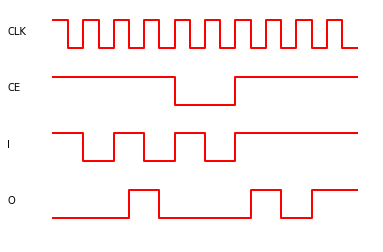

In [4]:
from magma.waveform import waveform

waveform(outputs, ["O", "I", "CE", "CLK"])